# On the Challenges of Pixel Art Generation using GANs

This notebook demonstrates how to train the models presented in the paper _"On the Challenges of Pixel Art Generation using GANs"_.
We start by importing Tensorflow, checking its version and the use of a GPU.


In [1]:
import tensorflow as tf

print("Tensorflow version: ", tf.__version__)

if tf.test.gpu_device_name():
    print("Default GPU: {}".format(tf.test.gpu_device_name()))
else:
    print("Not using a GPU - it will take long!!")

Tensorflow version:  2.9.1
Default GPU: /device:GPU:0


In [configuration.py](configuration.py) there are different settings related to the training procedure. The dataset is comprised of 294 pixel art character sprites in 4 different poses: back, left, front, right. Because of the train/test split (85%), only 250 sprites are used for training.

In [2]:
from configuration import *

print("DATASET_SIZE", DATASET_SIZE)
print("TRAIN_SIZE", TRAIN_SIZE)
print("TEST_SIZE", TEST_SIZE)

tf.random.set_seed(SEED)

DATASET_SIZE 294
TRAIN_SIZE 250
TEST_SIZE 44


## Choose Model to Train

In the next cell we can choose which model to train by setting the value of `model` to one of `["baseline (no aug.)", "baseline", "indexed", "histogram"]`. We can also define the source and target pose with values from `DIRECTION_BACK`, `DIRECTION_LEFT`, `DIRECTION_FRONT`, and `DIRECTION_RIGHT`.

In [3]:
MODELS = ["baseline (no aug.)", "baseline", "indexed", "histogram"]
model = MODELS[0]  # <-- CHOOSE the model to train here among [0, 1, 2, 3]
source_direction = DIRECTION_FRONT
target_direction = DIRECTION_RIGHT
architecture_name = f"{DIRECTIONS[source_direction]}-to-{DIRECTIONS[target_direction]}"

Now we load the dataset. Depending on the model being trained, the loading procedure is different. For instance, it may or may not apply data augmentation (hue rotation and translation). It also can load images as RGBA matrices or as indices in a color palette.

When training the palette-indexed model, we need to define how the palette colors are going to be sorted. The value can be one of `"grayness"`, `"top2bottom"`, `"bottom2top"`, or `"shuffled"`.

In [4]:
from dataset_utils import load_rgba_ds, load_indexed_ds

if model == "baseline (no aug.)":
    train_ds, test_ds = load_rgba_ds(source_direction, target_direction, augment=False)
elif model == "baseline":
    train_ds, test_ds = load_rgba_ds(source_direction, target_direction)
elif model == "indexed":
    train_ds, test_ds = load_indexed_ds(source_direction, target_direction,
                                        palette_ordering="grayness")     # "grayness", "top2bottom", "bottom2top", or "shuffled"
elif model == "histogram":
    train_ds, test_ds = load_rgba_ds(source_direction, target_direction)
else:
     raise SystemExit(f"The specified model {model} was not recognized. Use one of {MODELS}.")

After we load the dataset we can instantiate the model. This cell uses the value of the model chosen in the previous cells. And here we can define the values of some loss parameters, such as $\lambda_{L1}$, $\lambda_{cce}$ (`lambda_segmentation`), and $\lambda_{his}$ (`lambda_histogram`).

In [5]:
from pix2pix_model import Pix2PixModel, Pix2PixAugmentedModel, Pix2PixHistogramModel, Pix2PixIndexedModel

if model == "baseline (no aug.)":
    model = Pix2PixModel(
        train_ds=train_ds,
        test_ds=test_ds,
        model_name="baseline (no aug.)",  # subfolder in which to save the model and the generated images
        architecture_name=architecture_name,  # folder in which to save the model and the generated images
        lambda_l1=100.)

elif model == "baseline":
    model = Pix2PixAugmentedModel(
        train_ds=train_ds,
        test_ds=test_ds,
        model_name="baseline",
        architecture_name=architecture_name,
        lambda_l1=100.)

elif model == "indexed":
    model = Pix2PixIndexedModel(
        train_ds=train_ds,
        test_ds=test_ds,
        model_name="indexed",
        architecture_name=architecture_name,
        lambda_segmentation=0.01)

elif model == "histogram":
    model = Pix2PixHistogramModel(
        train_ds=train_ds,
        test_ds=test_ds,
        model_name="histogram",
        architecture_name=architecture_name,
        lambda_l1=30.,
        lambda_histogram=1.)

Generator: unet-gen with 29,307,844 parameters
Discriminator: patch-disc with 9,217 parameters


In [6]:
EPOCHS = 160
STEPS = ceil(TRAIN_SIZE / BATCH_SIZE) * EPOCHS
UPDATE_STEPS = STEPS // 40

print(f"Starting training for {EPOCHS} epochs in {STEPS} steps, updating visualization every {UPDATE_STEPS} steps...")

Starting training for 160 epochs in 10080 steps, updating visualization every 252 steps...


Now we start training. The output of this cell will be updated a number of times equal to `40` (i.e., every `UPDATE_STEPS`). When each evaluation step happens, the cell shows the generated images of 3 examples from the test set and 3 from training. Besides, the callbacks provided to the `fit` method are executed, yielding:

- `show_discriminator_output`: shows an image with the logits of the current discriminator for 2 examples from the training set and 2 from the test set. This allows debugging which patches of the images are being considered real (white) or fake (black) by the discriminator.
- `evaluate_fid`: calculates FID scores for the images created by the current generator comparing to the target. Both images from the training and test datasets are considered separately, allowing the identification of model overfitting.
- `evaluate_l1`: calculates the L1 distance to the target images, both from the test and training datasets.

For more frequent, detailed and graphical information, we can open Tensorboard with its log directory pointing to `temp-side2side`.

Time since start: 36m:04s
Estimated time to finish: 00m:00s
Last 252 steps took: 51.48s

Previewing images generated at step 10080 (3 test + 3 train)...


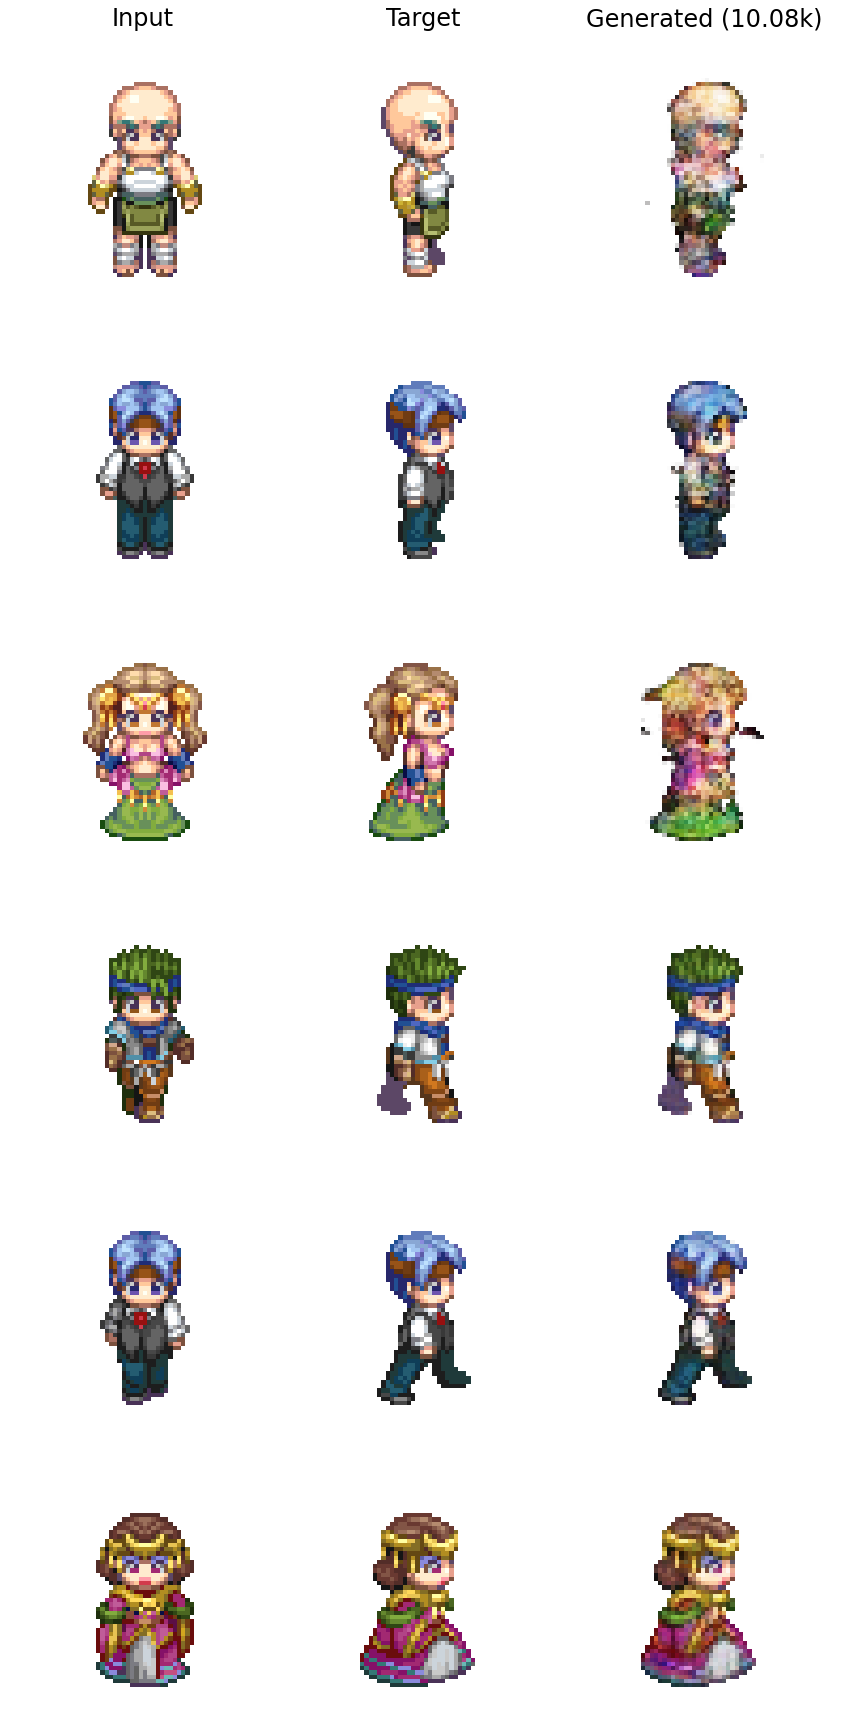

Showing discriminator output patches (2 test + 2 train)...


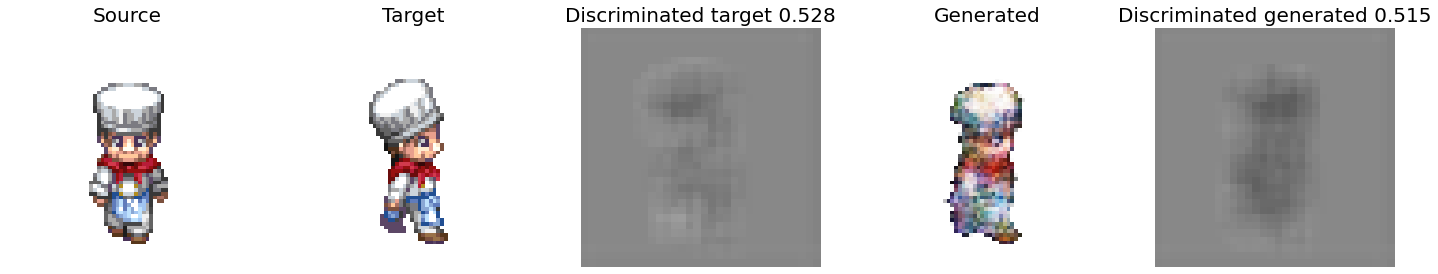

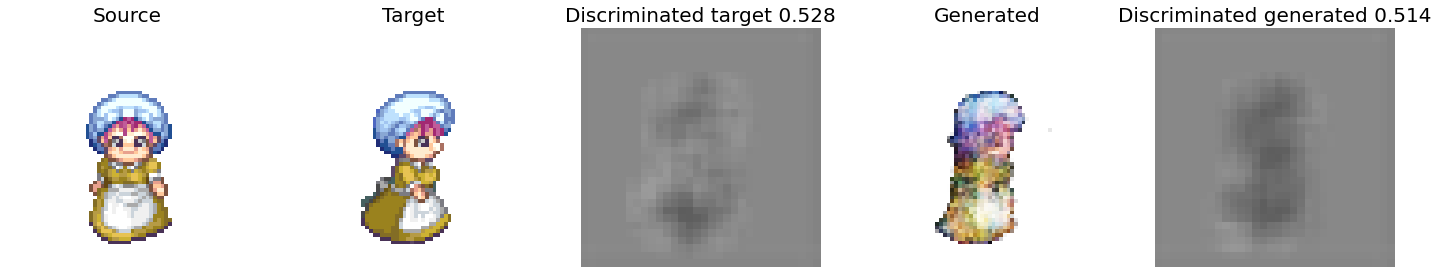

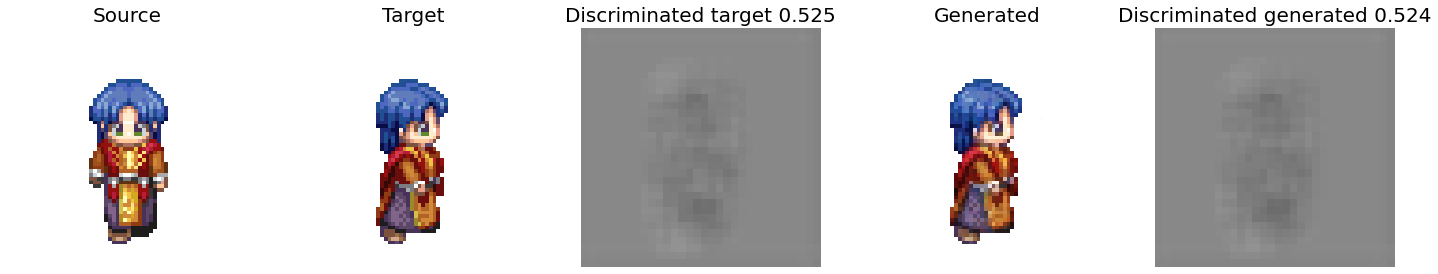

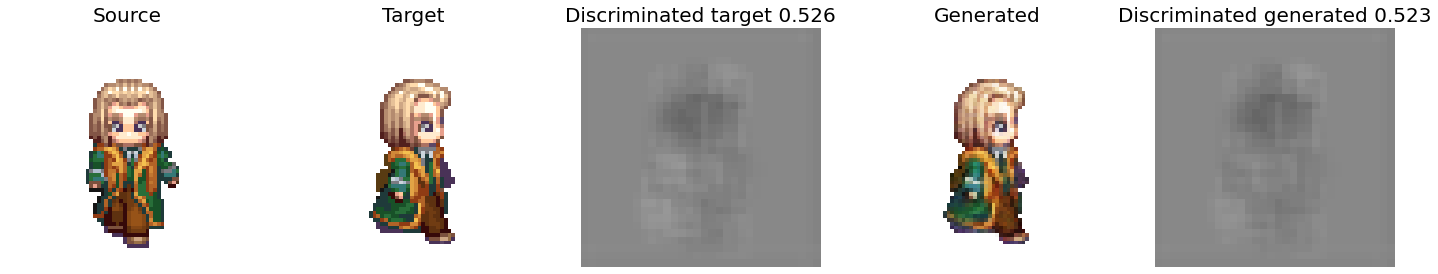

Comparing L1 between generated images from train and test... L1: 0.00789 / 0.06371 (train/test)
Calculating Fréchet Inception Distance at 10.08k with 44 examples...
2/2 [==============================] - 0s 241ms/step
FID: 0.330 / 10.931 (train/test)
Step: 10.08k


In [7]:
SAVE_THE_MODEL_WEIGHTS = False
GENERATE_ALL_IMAGES_FROM_TEST = True

model.fit(STEPS, UPDATE_STEPS, callbacks=["show_discriminator_output", "evaluate_fid", "evaluate_l1"])

## Saving the Model

We can save the model weights. They are stored in the `models/py/{generator,discriminator}/ARCHITECTURE/MODEL_NAME/` path.

In [8]:
if SAVE_THE_MODEL_WEIGHTS:
    model.save_generator()
    model.save_discriminator()

## Visualizing Results

We can generate images from all of the examples in the test dataset. We can also inspect the discriminator output in the next cell.

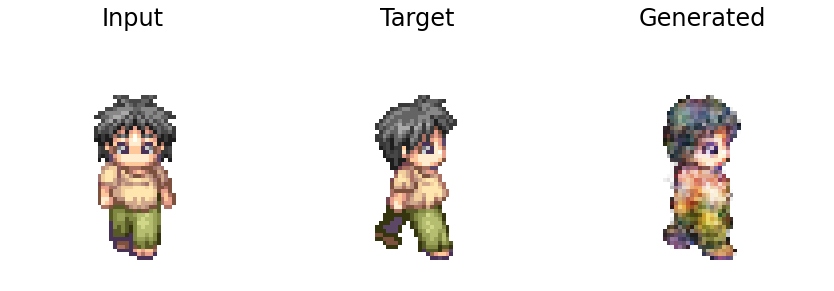

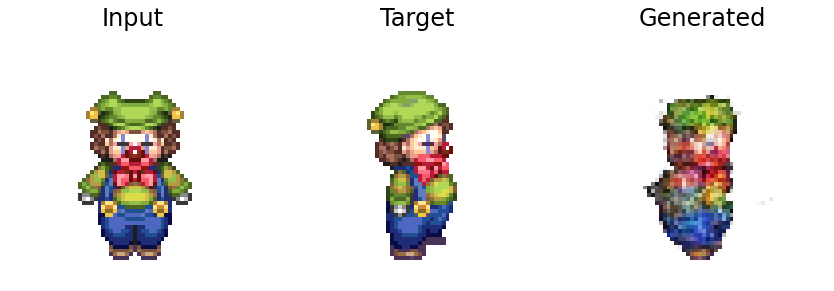

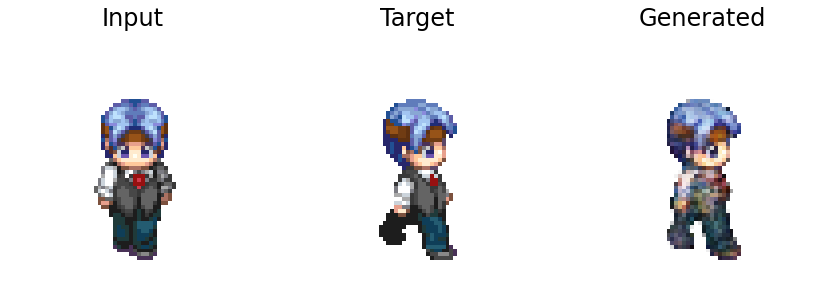

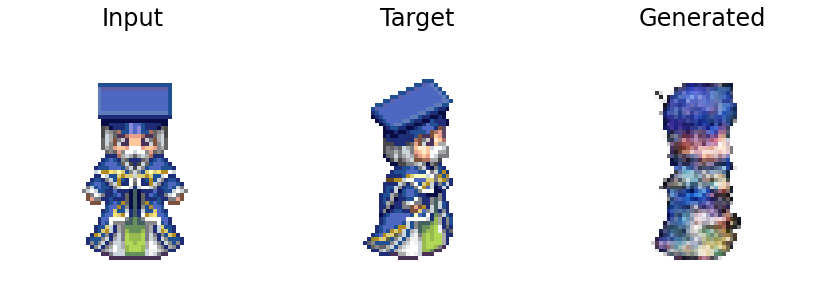

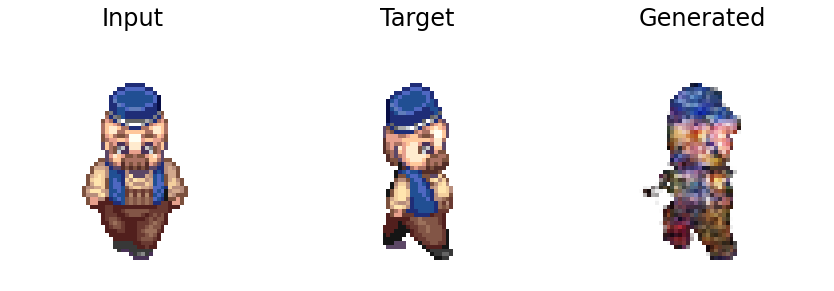

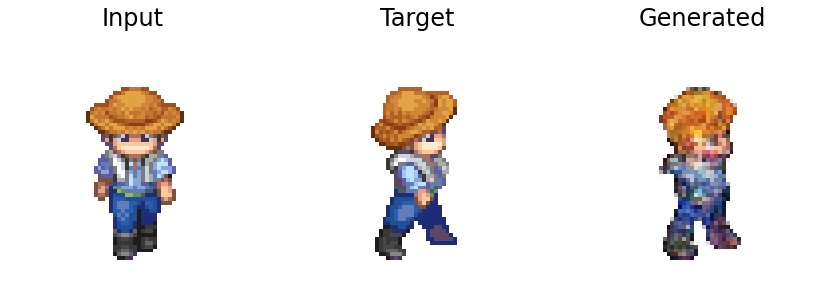

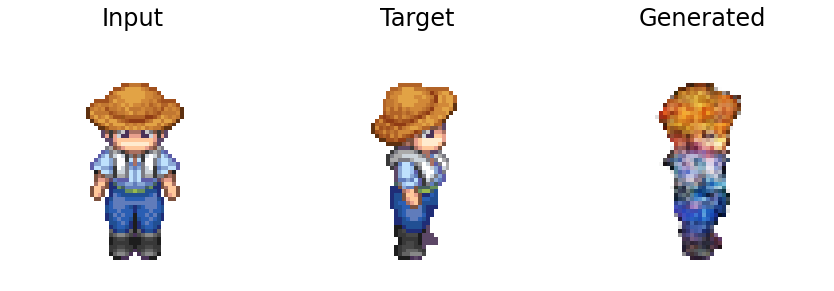

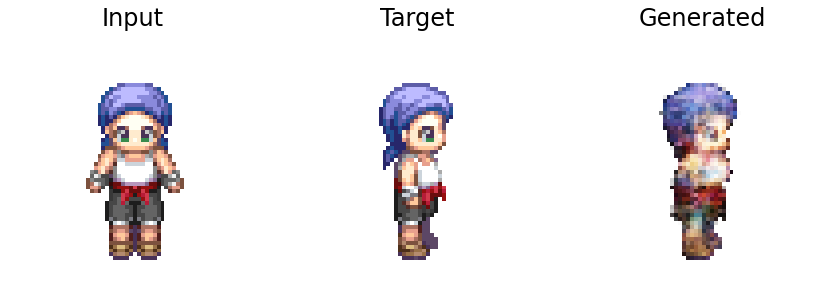

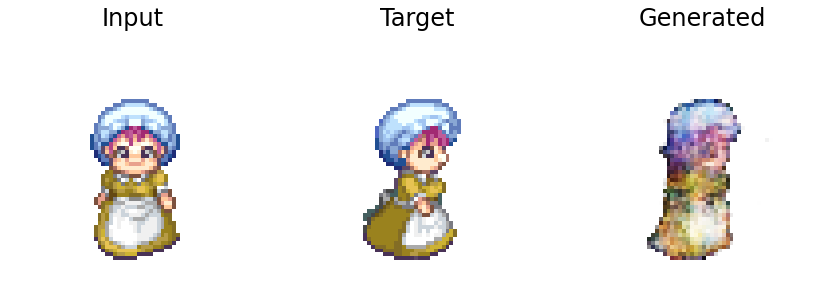

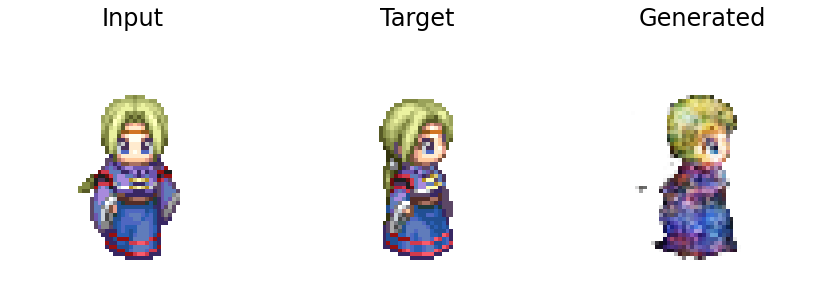

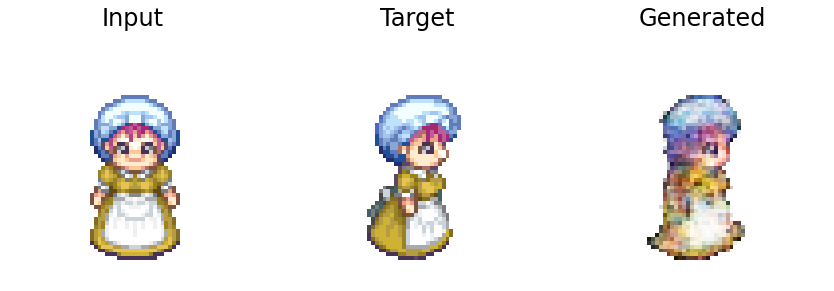

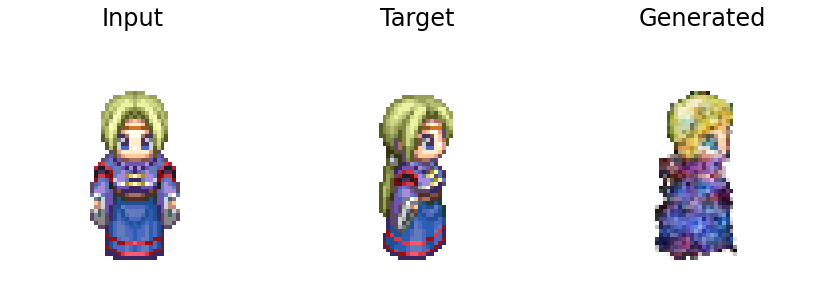

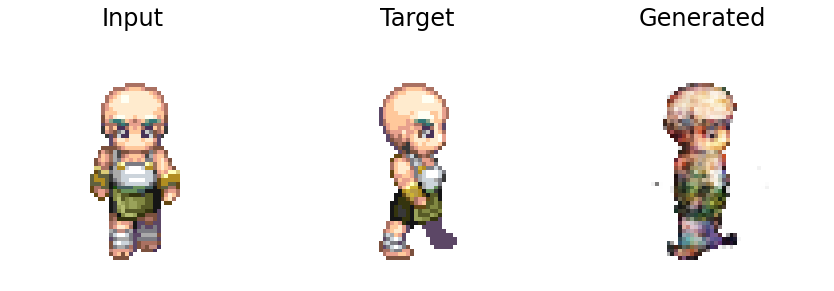

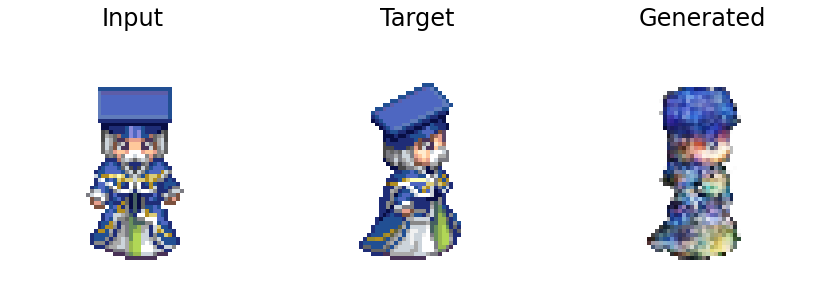

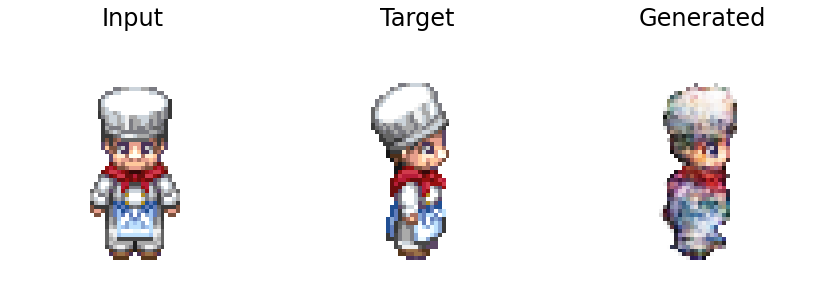

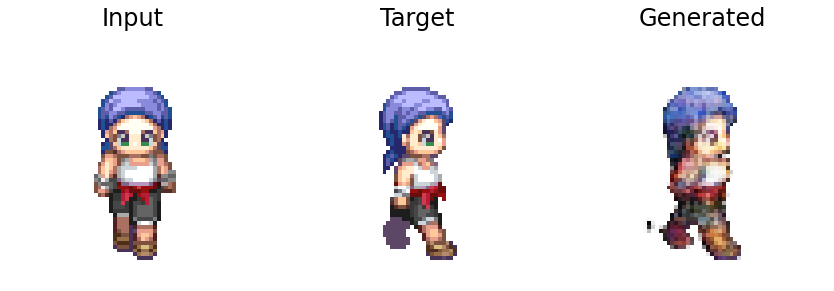

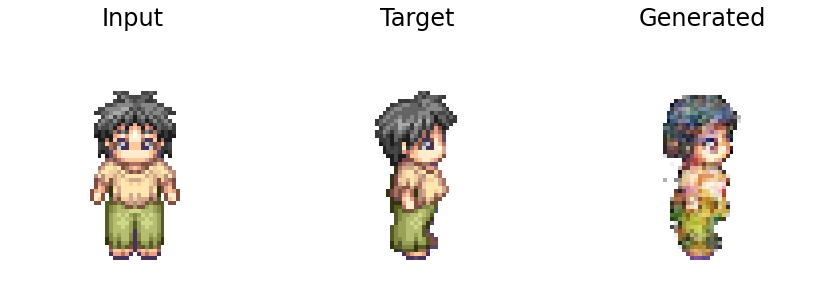

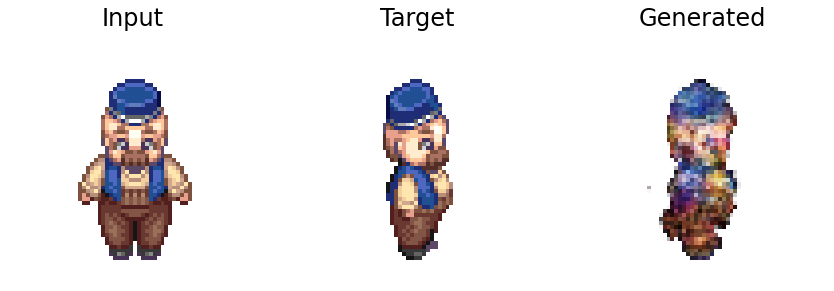

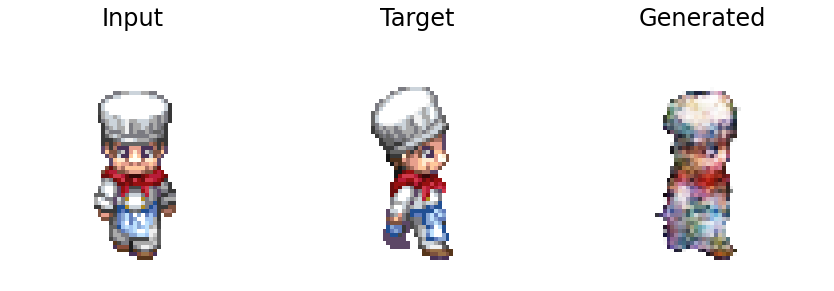

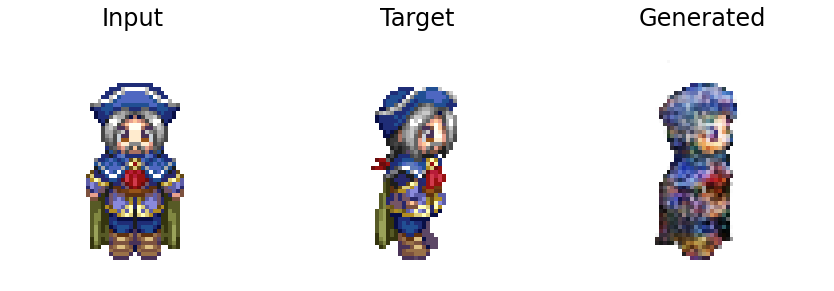

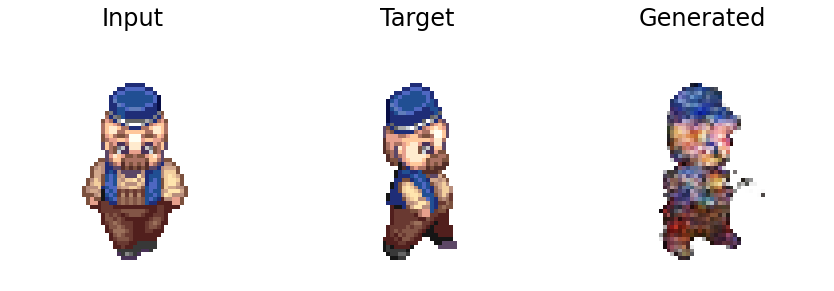

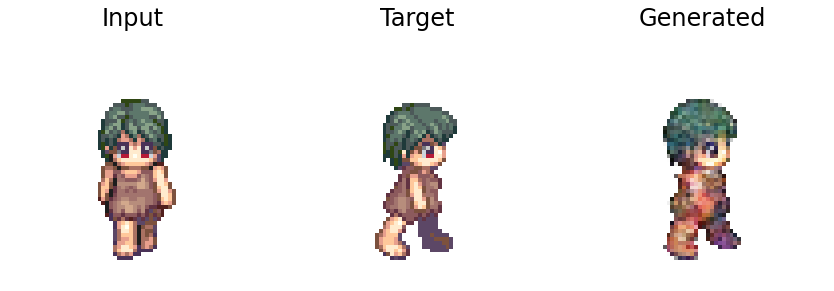

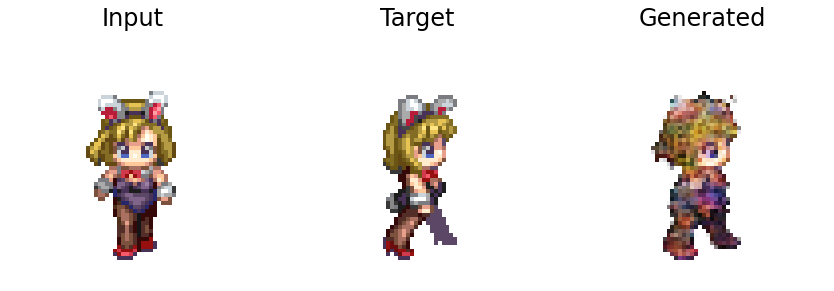

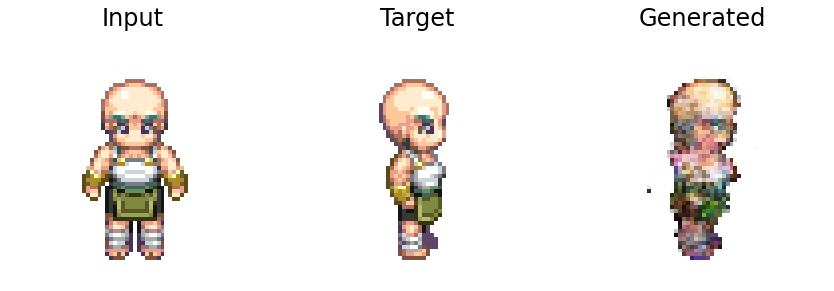

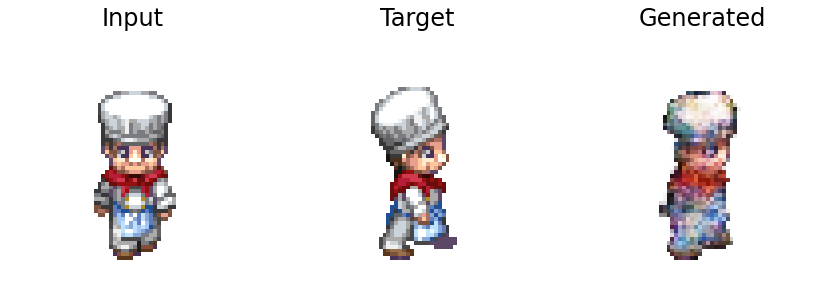

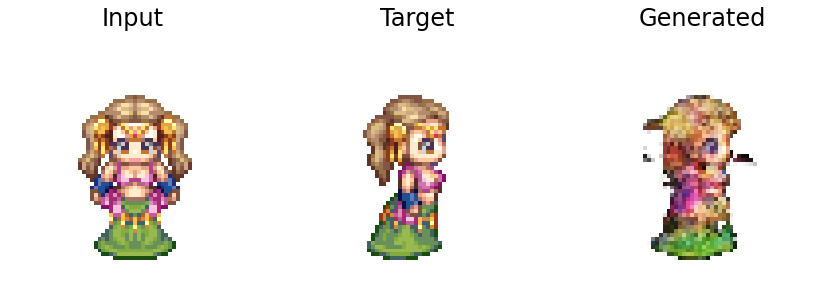

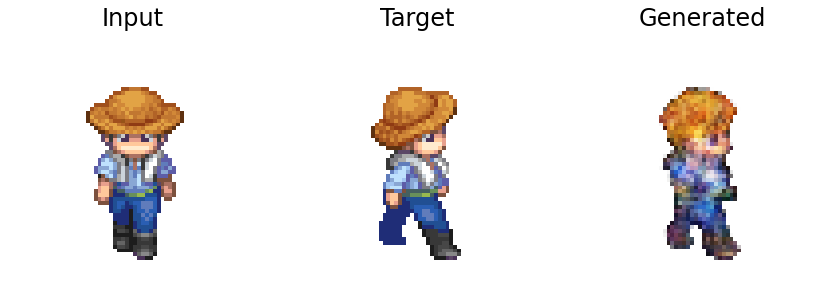

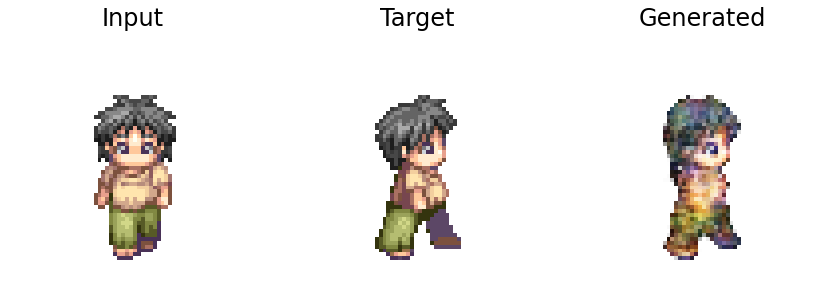

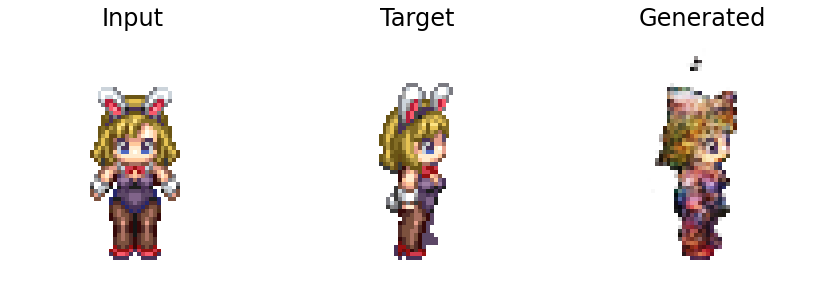

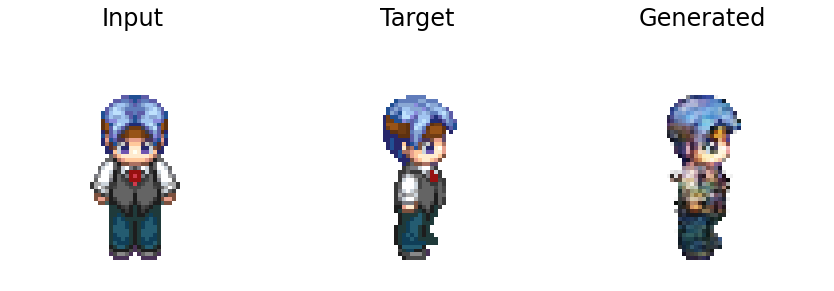

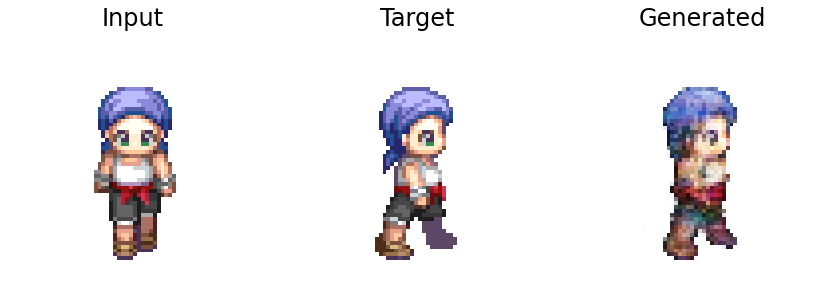

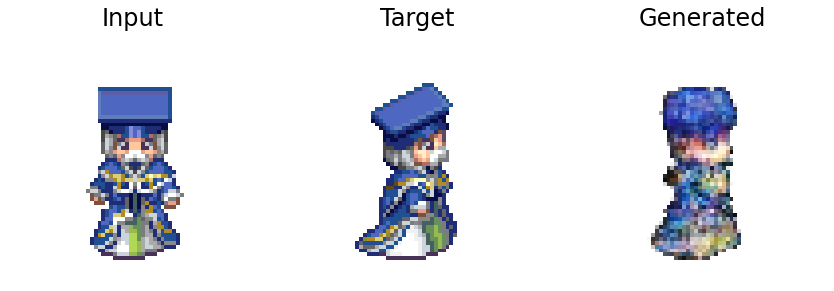

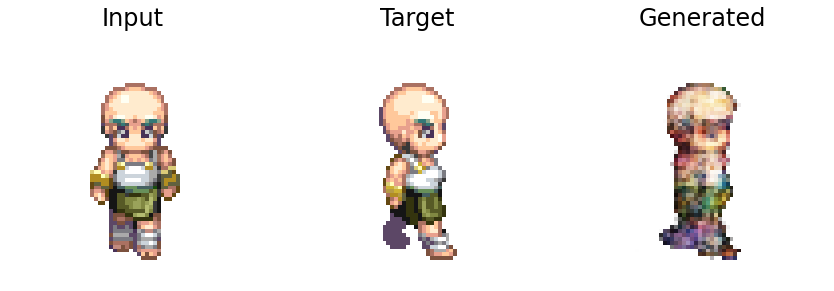

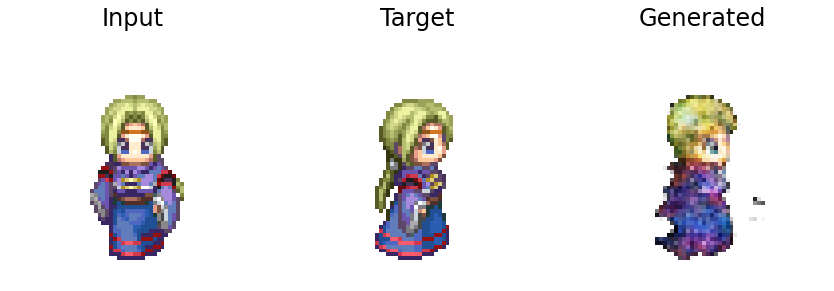

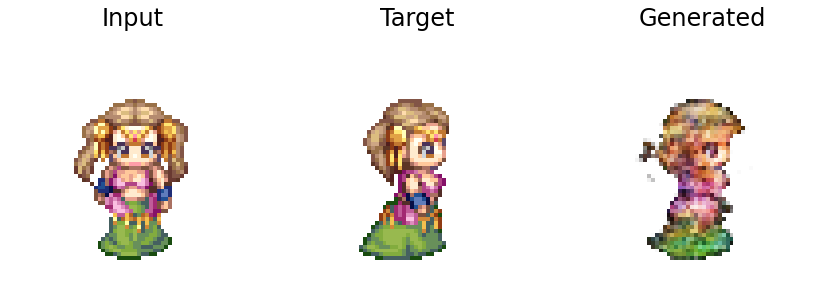

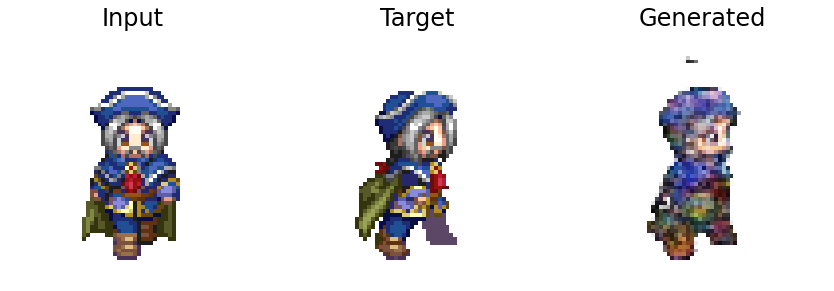

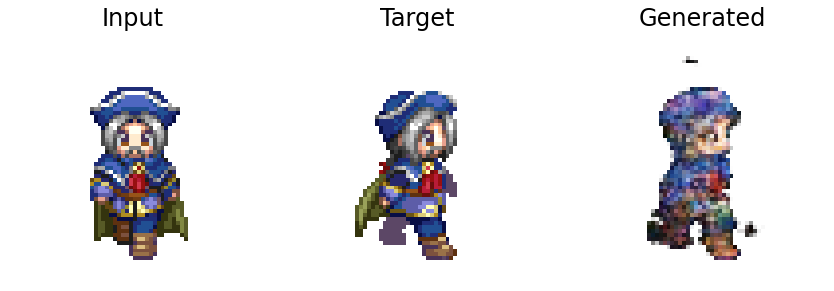

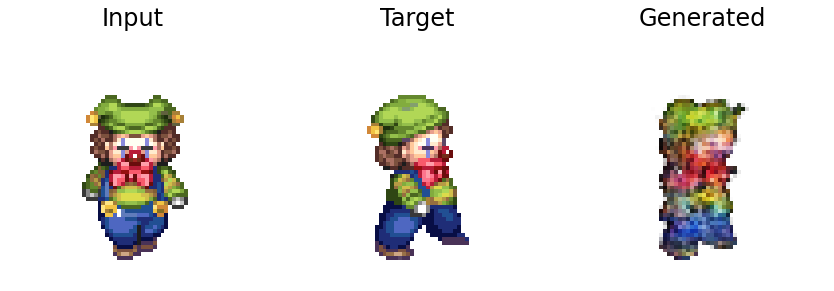

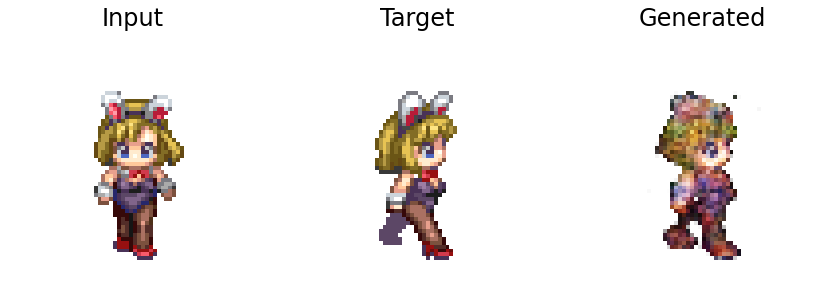

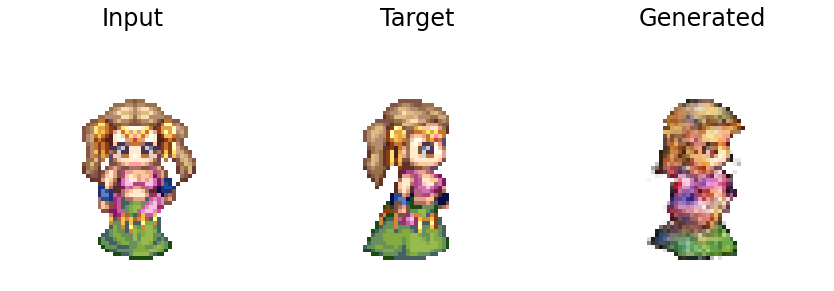

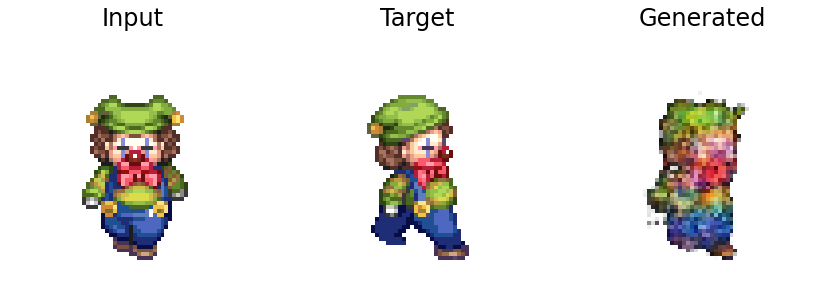

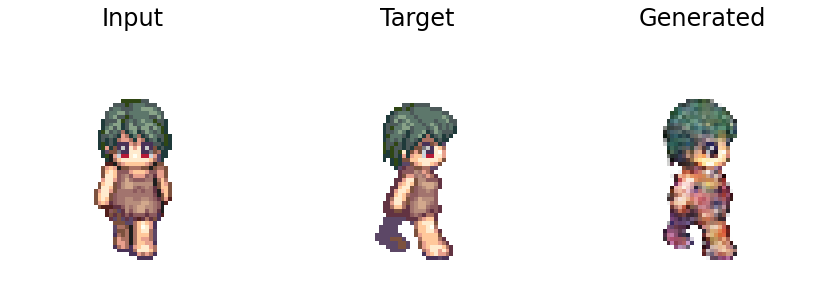

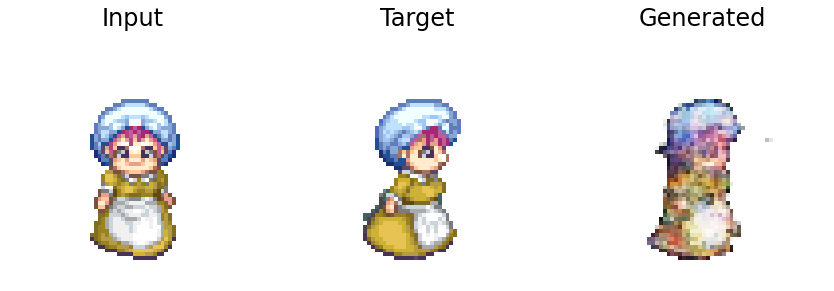

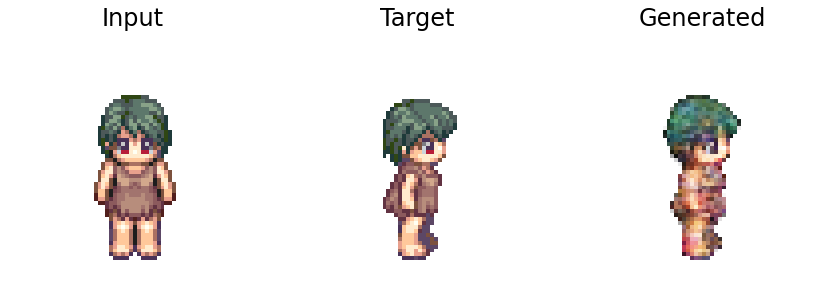

Generated 44 images (using "test" dataset)


In [9]:
if GENERATE_ALL_IMAGES_FROM_TEST:
    model.generate_images_from_dataset()

Showing discriminator output from the TEST set...


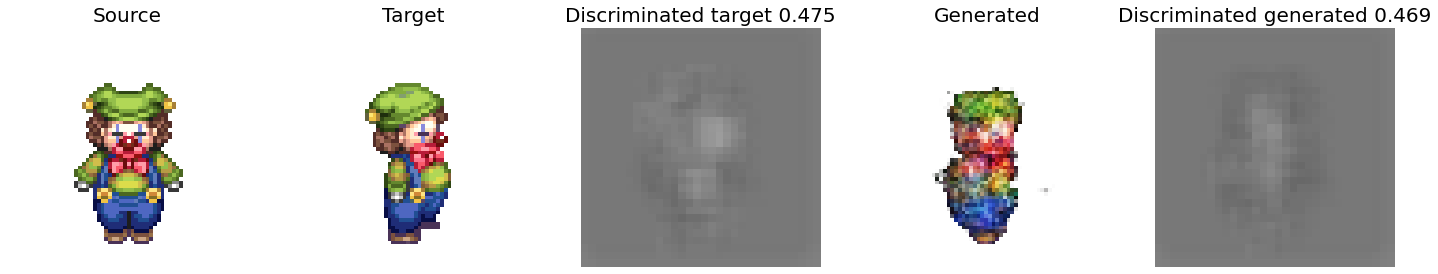

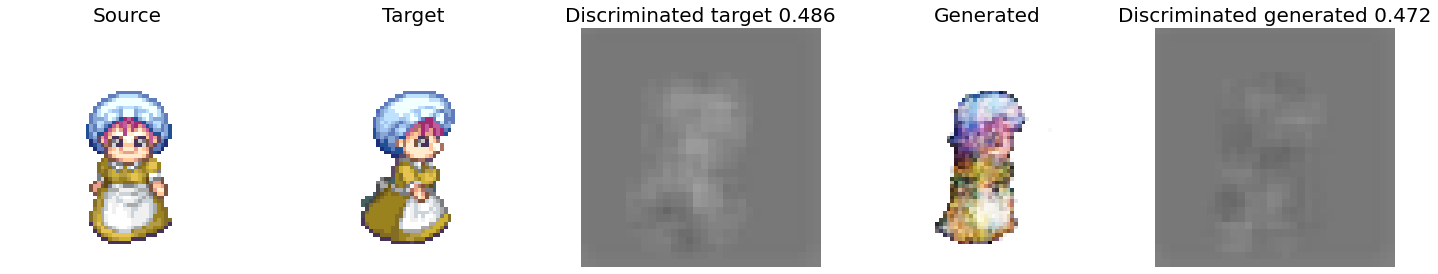

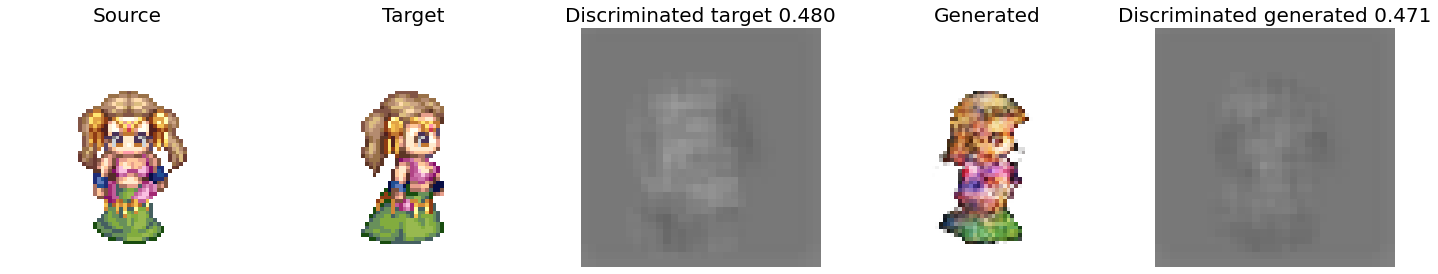

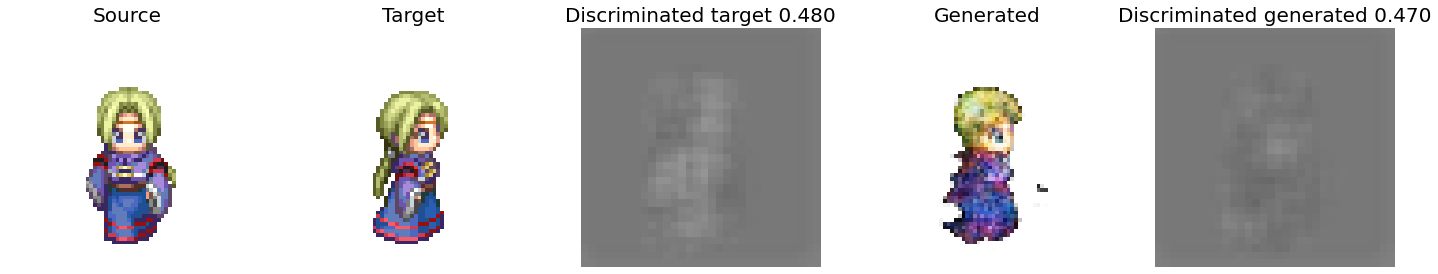

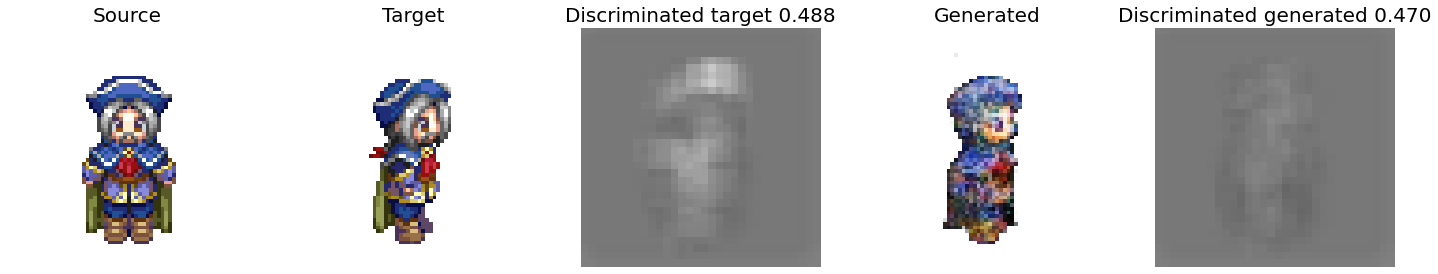

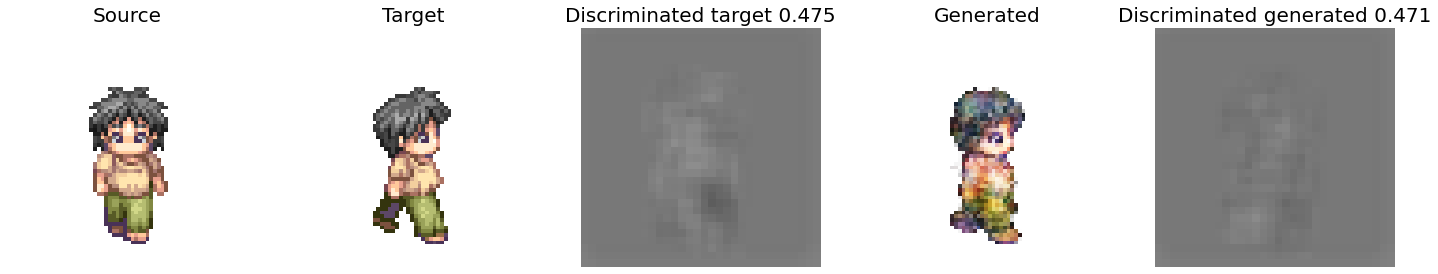

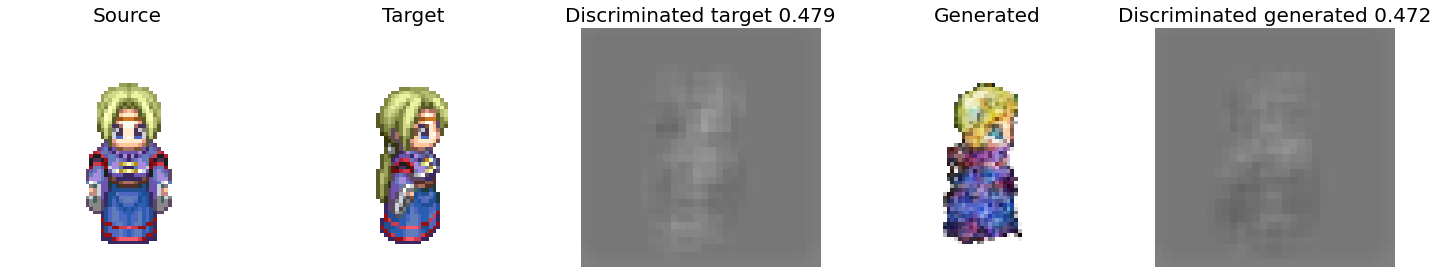

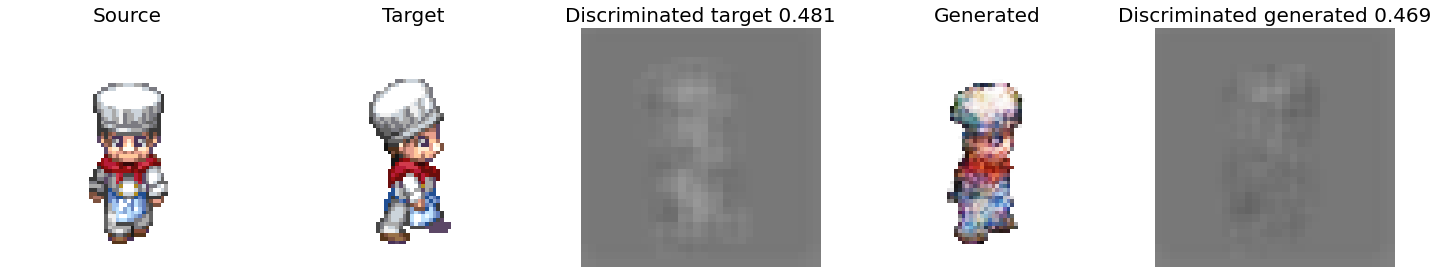

Showing discriminator output from the TRAIN set...


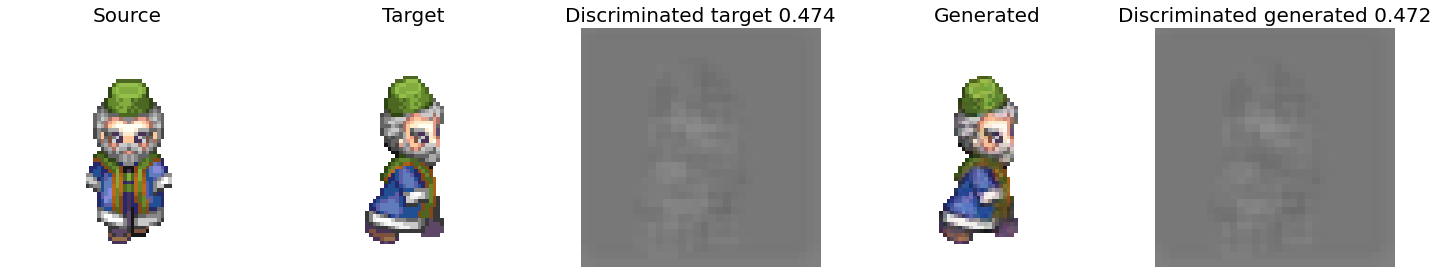

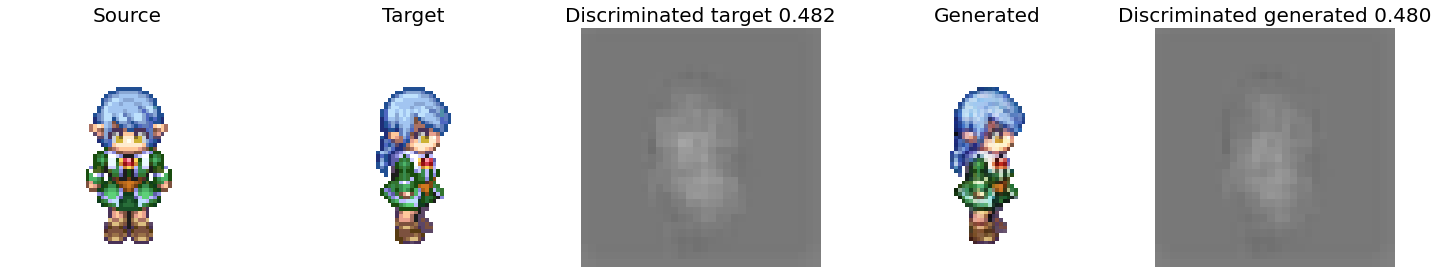

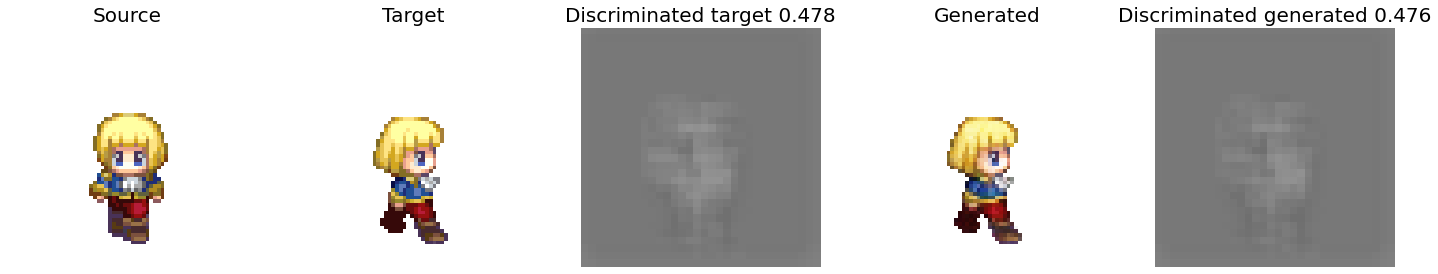

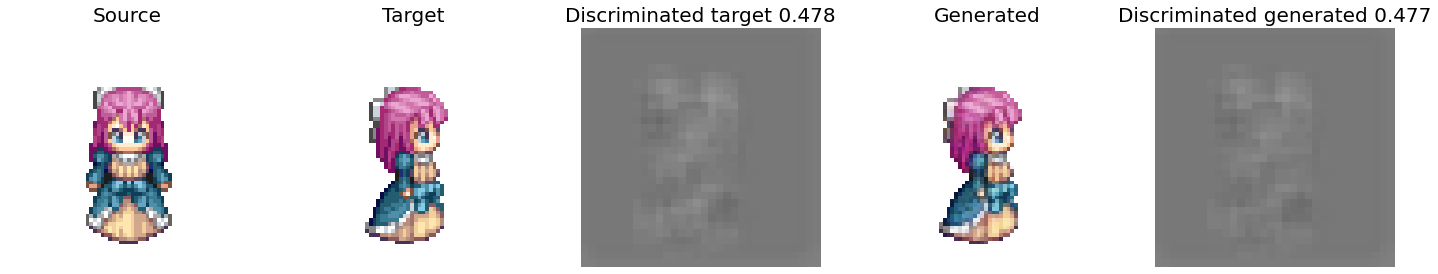

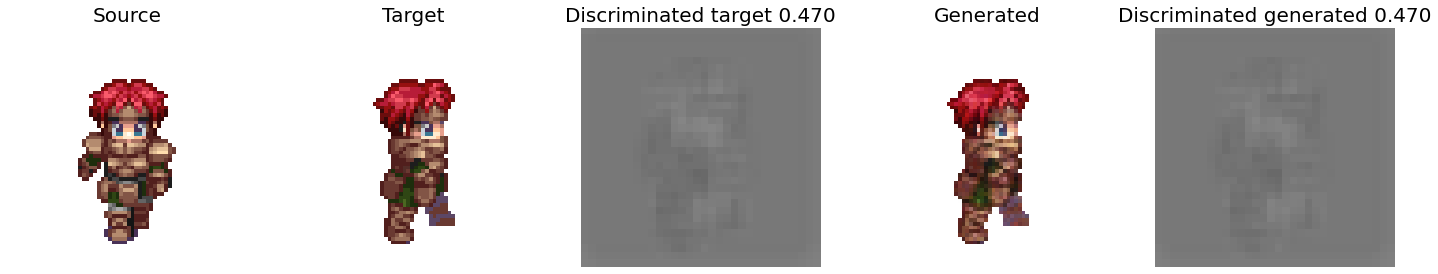

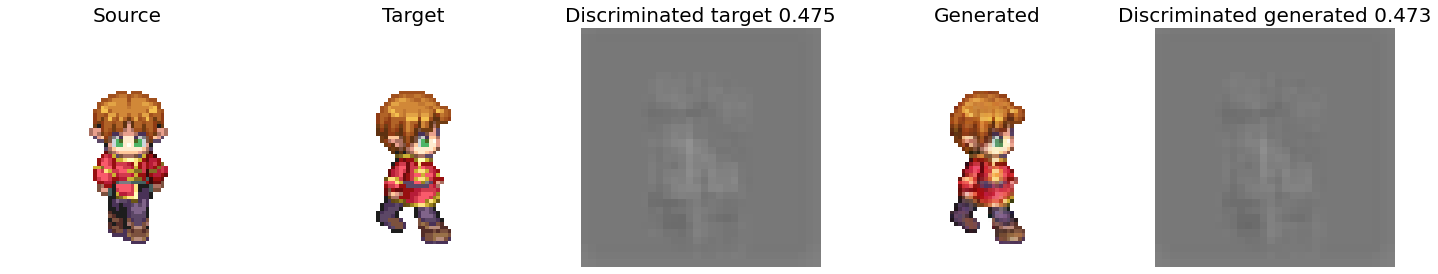

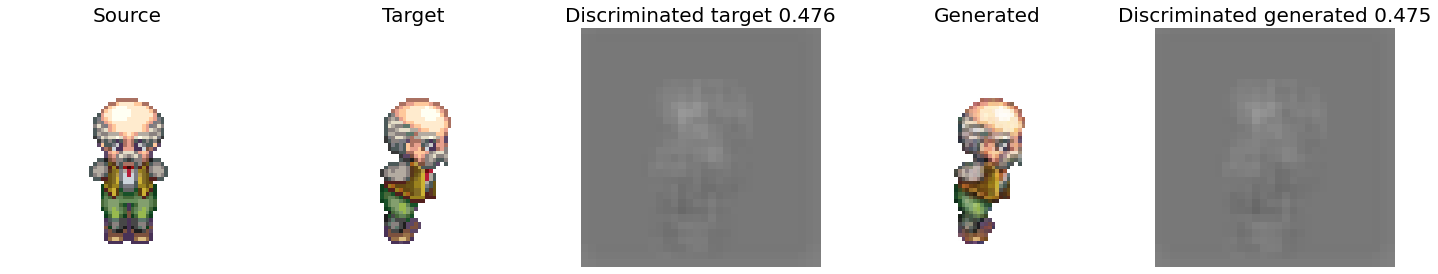

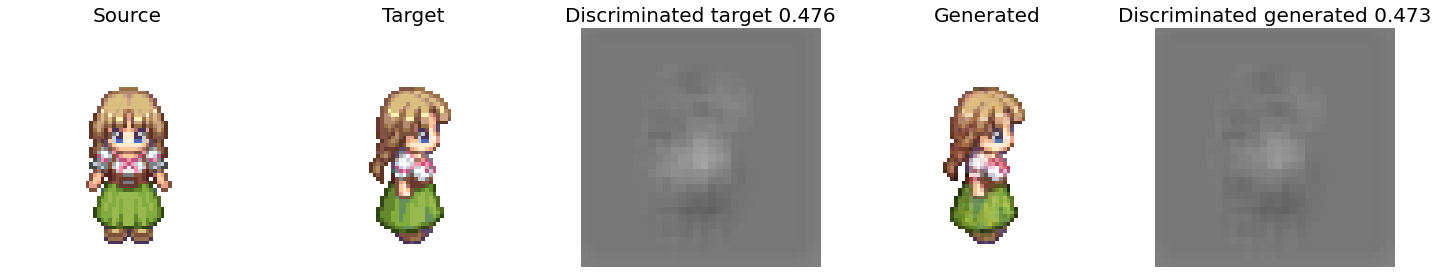

In [10]:
print("Showing discriminator output from the TEST set...")
model.show_discriminated_images("test", 8)

print("Showing discriminator output from the TRAIN set...")
model.show_discriminated_images("train", 8)